# Ivan Alexander Ramos Ramirez A01750817
# Módulo 2  Análisis y Reporte sobre 
#  el desempeño del modelo. (Portafolio Implementación)

In [43]:
from Neural import NeuralNet
from Neural import stratified_split
#cross validation
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

In [44]:
from sklearn.datasets import load_digits

In [45]:
digits = load_digits()
X, y = digits.data, digits.target

print("Shape de X:", X.shape)   # (1797, 64)
print("Shape de y:", y.shape)   # (1797,)
print("Clases:", set(y))        # {0,1,2,...,9}
print("Número de muestras:", len(y))
print("Número de features:", X.shape[1])
print("Dimensión de cada imagen:", digits.images[0].shape)

Shape de X: (1797, 64)
Shape de y: (1797,)
Clases: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
Número de muestras: 1797
Número de features: 64
Dimensión de cada imagen: (8, 8)


In [46]:
# Congelar copias crudas para evitar contaminación por ejecuciones previas
X_raw = X.astype(np.float64).copy()
y_raw = y.copy()

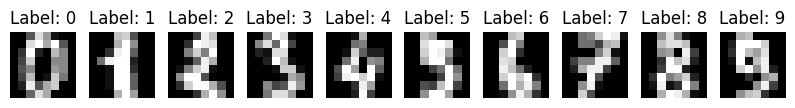

In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.show()


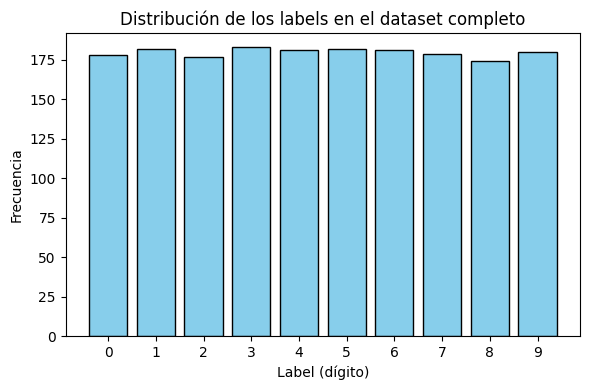

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizar la distribución de los labels del target en el dataset completo
labels, counts = np.unique(y_raw, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color='skyblue', edgecolor='k')
plt.xlabel('Label (dígito)')
plt.ylabel('Frecuencia')
plt.title('Distribución de los labels en el dataset completo')
plt.xticks(labels)
plt.tight_layout()
plt.show()

In [49]:
labels, counts = np.unique(y_raw, return_counts=True)
percentages = 100 * counts / counts.sum()

for label, pct in zip(labels, percentages):
    print(f"Label {label}: {pct:.2f}%")

Label 0: 9.91%
Label 1: 10.13%
Label 2: 9.85%
Label 3: 10.18%
Label 4: 10.07%
Label 5: 10.13%
Label 6: 10.07%
Label 7: 9.96%
Label 8: 9.68%
Label 9: 10.02%


In [50]:
# Diagnóstico de varianza y NaNs antes del escalado (usar X_raw)
stds_raw = X_raw.std(axis=0)
zero_var_count = np.sum((stds_raw == 0) | ~np.isfinite(stds_raw))
print("Features con varianza cero o std no finita:", int(zero_var_count))
print("Alguna NaN en X_raw?", np.isnan(X_raw).any())

Features con varianza cero o std no finita: 3
Alguna NaN en X_raw? False


In [51]:
# Comprobaciones sobre datos crudos (definir X_before_scaling)
X_before_scaling = X_raw
assert np.issubdtype(X_before_scaling.dtype, np.number), "Non-numeric dtype detected"

# Pre-existing non-finites, esto sirve para identificar NaNs o infs en los datos
print("Raw non-finites:", (~np.isfinite(X_before_scaling)).sum())

# Zero-variance columns (σ = 0), esto sirve para identificar columnas que no aportan información
std0_cols = np.where(np.nanstd(X_before_scaling, axis=0) == 0)[0]
print("Zero-variance cols:", std0_cols)

Raw non-finites: 0
Zero-variance cols: [ 0 32 39]


In [52]:
# Configurar y entrenar la red
modelo1 = NeuralNet(
    learning_rate=0.01,
    activation_function='ReLu',
    layer_neurons=[32, 16],  # un poco más de capacidad que [6,4]
    epoch=200,
    batch_size=32
)

# Usar copias crudas para evitar contaminación
X_use = X_raw
y_use = y_raw

# Asegurar y 1D
if y_use.ndim > 1:
    y_use = y_use.ravel()

X_raw shape: (1797, 64)
Rango (raw): 0.0 → 16.0


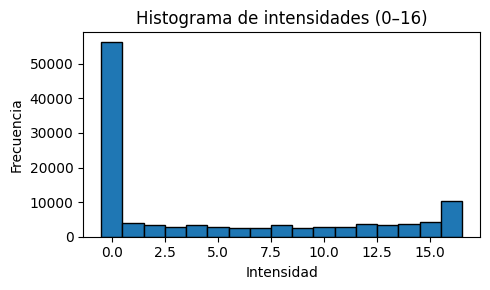

In [53]:
import numpy as np
import matplotlib.pyplot as plt

print("X_raw shape:", X_raw.shape)  # (1797, 64)
print("Rango (raw):", X_raw.min(), "→", X_raw.max())

plt.figure(figsize=(5,3))
plt.hist(X_raw.ravel(), bins=np.arange(-0.5, 17.5, 1), edgecolor='k')
plt.title("Histograma de intensidades (0–16)")
plt.xlabel("Intensidad"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

In [54]:
X_train, X_test, X_val, y_train, y_test, y_val = stratified_split(X_use, y_use, test_size=0.15, validation_size=0.15)

In [55]:

# Guardar copias sin escalar para CV y escalado reproducible
X_train_raw = X_train.copy()
X_val_raw = X_val.copy()
X_test_raw = X_test.copy()

# Estadísticos del train usando SOLO train_raw
mean_train = X_train_raw.mean(axis=0)
std_train = X_train_raw.std(axis=0)

# Evitar std = 0 o NaN
std_train = np.nan_to_num(std_train, nan=0.0)
std_train[std_train == 0] = 1.0

# Escalado para el entrenamiento base y test (no contamina CV)
X_train = (X_train_raw - mean_train) / std_train
X_test = (X_test_raw - mean_train) / std_train


In [56]:

# Split primero, luego escalar con estadísticos del train
# mostrando la separacion de los datos
print("original Shape:", X_use.shape, y_use.shape)
print("Train shape:", X_train.shape, y_train.shape, f"{100 * len(y_train) / len(y_use):.1f}%")
print("Test shape:", X_test.shape, y_test.shape, f"{100 * len(y_test) / len(y_use):.1f}%")
print("Validation shape:", X_val.shape, y_val.shape, f"{100 * len(y_val) / len(y_use):.1f}%")


original Shape: (1797, 64) (1797,)
Train shape: (1265, 64) (1265,) 70.4%
Test shape: (266, 64) (266,) 14.8%
Validation shape: (266, 64) (266,) 14.8%


In [57]:



# Chequeos rápidos de sanidad, esto ayuda a detectar problemas antes de entrenar
assert np.isfinite(X_train).all() and np.isfinite(X_test).all(), "Hay NaN/Inf tras el escalado"


In [58]:

# Entrenamiento
modelo1.fit(X_train, y_train)

# Predicción y métricas
y_pred = modelo1.predict(X_test)
class_to_idx = {c: i for i, c in enumerate(modelo1.classes)}
y_test_idx = np.array([class_to_idx[label] for label in y_test])

test_acc = np.mean(y_pred == y_test_idx)
print(f"Accuracy test: {test_acc:.3f}")

# Pérdida de test
y_pred_test, _, _ = modelo1._forward(X_test)
print(f"Loss test: {modelo1._CategoricalCrossEntropy(y_test_idx, y_pred_test):.3f}")

Epoch   1 | loss=2.7477 | acc=0.196
Epoch  10 | loss=0.7063 | acc=0.855
Epoch  20 | loss=0.2781 | acc=0.944
Epoch  20 | loss=0.2781 | acc=0.944
Epoch  30 | loss=0.1669 | acc=0.962
Epoch  40 | loss=0.1163 | acc=0.977
Epoch  30 | loss=0.1669 | acc=0.962
Epoch  40 | loss=0.1163 | acc=0.977
Epoch  50 | loss=0.0885 | acc=0.989
Epoch  50 | loss=0.0885 | acc=0.989
Epoch  60 | loss=0.0680 | acc=0.991
Epoch  70 | loss=0.0548 | acc=0.992
Epoch  60 | loss=0.0680 | acc=0.991
Epoch  70 | loss=0.0548 | acc=0.992
Epoch  80 | loss=0.0453 | acc=0.993
Epoch  90 | loss=0.0375 | acc=0.996
Epoch  80 | loss=0.0453 | acc=0.993
Epoch  90 | loss=0.0375 | acc=0.996
Epoch 100 | loss=0.0317 | acc=0.996
Epoch 100 | loss=0.0317 | acc=0.996
Epoch 110 | loss=0.0284 | acc=0.998
Epoch 120 | loss=0.0235 | acc=0.998
Epoch 110 | loss=0.0284 | acc=0.998
Epoch 120 | loss=0.0235 | acc=0.998
Epoch 130 | loss=0.0204 | acc=0.999
Epoch 140 | loss=0.0180 | acc=0.999
Epoch 130 | loss=0.0204 | acc=0.999
Epoch 140 | loss=0.0180 | ac

In [61]:
#evaluacion inicial del modelo con metricas
from sklearn.metrics import classification_report, accuracy_score

# y_pred_te ya contiene las predicciones del test
# y_test_idx son los índices verdaderos

# Convertir probabilidades a índices de clase
y_pred_test_idx = np.argmax(y_pred_test, axis=1)

print("Accuracy:", accuracy_score(y_test_idx, y_pred_test_idx))
print("Reporte de clasificación:")
print(classification_report(y_test_idx, y_pred_test_idx, digits=3))

Accuracy: 0.9624060150375939
Reporte de clasificación:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        26
           1      0.960     0.889     0.923        27
           2      0.962     0.962     0.962        26
           3      0.963     0.963     0.963        27
           4      0.931     1.000     0.964        27
           5      1.000     1.000     1.000        27
           6      1.000     0.926     0.962        27
           7      1.000     0.962     0.980        26
           8      0.889     0.923     0.906        26
           9      0.931     1.000     0.964        27

    accuracy                          0.962       266
   macro avg      0.964     0.962     0.962       266
weighted avg      0.964     0.962     0.962       266



Train acc=1.000 loss=0.010
Val   acc=0.951 loss=0.336  (gap=0.049)
Test  acc=0.962 loss=0.246 (gap=0.038)
Diagnóstico de bias: bajo
Indicadores: alta precisión en train. Si el gap es grande, el problema es varianza (overfitting).


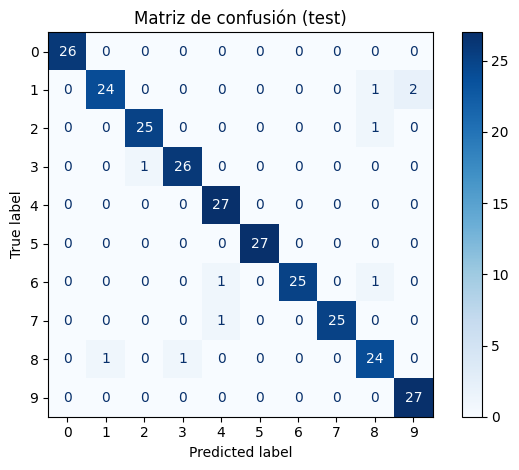

In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Escalar validación con las estadísticas del train (si no lo hiciste antes)
X_val_s = (X_val_raw - mean_train) / std_train

# Predicciones
y_pred_tr = modelo1.predict(X_train)
y_pred_va = modelo1.predict(X_val_s)
y_pred_te = modelo1.predict(X_test)

# Mapear labels → índices según el modelo
class_to_idx = {c: i for i, c in enumerate(modelo1.classes)}
y_train_idx = np.array([class_to_idx[l] for l in y_train])
y_val_idx   = np.array([class_to_idx[l] for l in y_val])
y_test_idx  = np.array([class_to_idx[l] for l in y_test])

# Accuracies
train_acc = (y_pred_tr == y_train_idx).mean()
val_acc   = (y_pred_va == y_val_idx).mean()
test_acc  = (y_pred_te == y_test_idx).mean()

# Losses (usa el forward y la CCE del modelo)
p_tr, _, _ = modelo1._forward(X_train)
p_va, _, _ = modelo1._forward(X_val_s)
p_te, _, _ = modelo1._forward(X_test)
train_loss = modelo1._CategoricalCrossEntropy(y_train_idx, p_tr)
val_loss   = modelo1._CategoricalCrossEntropy(y_val_idx, p_va)
test_loss  = modelo1._CategoricalCrossEntropy(y_test_idx, p_te)

# Heurística de nivel de bias según train_acc (umbral típico para Digits)
def nivel_bias(acc):
    if acc <= 0.80: return "alto"
    if acc <= 0.92: return "medio"
    return "bajo"

bias = nivel_bias(train_acc)
gap_va = train_acc - val_acc
gap_te = train_acc - test_acc

print(f"Train acc={train_acc:.3f} loss={train_loss:.3f}")
print(f"Val   acc={val_acc:.3f} loss={val_loss:.3f}  (gap={gap_va:.3f})")
print(f"Test  acc={test_acc:.3f} loss={test_loss:.3f} (gap={gap_te:.3f})")
print(f"Diagnóstico de bias: {bias}")
if bias == "alto":
    print("Indicadores: baja precisión en train y valid/test → subajuste. Sube capacidad/épocas o ajusta LR/init.")
elif bias == "medio":
    print("Indicadores: precisión moderada en train; aún margen de mejora. Ajusta capacidad/épocas/LR.")
else:
    print("Indicadores: alta precisión en train. Si el gap es grande, el problema es varianza (overfitting).")

# Matriz de confusión (test)
cm = confusion_matrix(y_test_idx, y_pred_te)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (test)")
plt.tight_layout(); plt.show()

In [63]:
#Diagnóstico y explicación el grado de varianza: bajo medio alto

def nivel_varianza(gap):
    if gap < 0.03:
        return "bajo"
    elif gap < 0.08:
        return "medio"
    else:
        return "alto"

varianza_val = nivel_varianza(gap_va)
varianza_test = nivel_varianza(gap_te)

print(f"Varianza (train vs val): {varianza_val} (gap={gap_va:.3f})")
print(f"Varianza (train vs test): {varianza_test} (gap={gap_te:.3f})")

if varianza_val == "alto" or varianza_test == "alto":
    print("Indicadores: el modelo sobreajusta (overfitting). Reduce capacidad, agrega regularización o usa más datos.")
elif varianza_val == "medio" or varianza_test == "medio":
    print("Indicadores: hay algo de sobreajuste, pero no crítico. Puedes ajustar regularización o probar más datos.")
else:
    print("Indicadores: la varianza es baja, el modelo generaliza bien.")

Varianza (train vs val): medio (gap=0.049)
Varianza (train vs test): medio (gap=0.038)
Indicadores: hay algo de sobreajuste, pero no crítico. Puedes ajustar regularización o probar más datos.


Epoch   1 | loss=3.0291 | acc=0.024
Epoch  10 | loss=2.2230 | acc=0.270
Epoch  20 | loss=1.8156 | acc=0.429
Epoch  30 | loss=1.5426 | acc=0.556
Epoch  40 | loss=1.3277 | acc=0.619
Epoch  50 | loss=1.1567 | acc=0.683
Epoch  60 | loss=1.0124 | acc=0.738
Epoch  70 | loss=0.8855 | acc=0.778
Epoch  80 | loss=0.7803 | acc=0.794
Epoch  90 | loss=0.6847 | acc=0.810
Epoch 100 | loss=0.6027 | acc=0.833
Epoch 110 | loss=0.5238 | acc=0.889
Epoch 120 | loss=0.4610 | acc=0.913
Epoch 130 | loss=0.4039 | acc=0.937
Epoch 140 | loss=0.3544 | acc=0.952
Epoch 150 | loss=0.3126 | acc=0.952
Epoch 160 | loss=0.2752 | acc=0.968
Epoch 170 | loss=0.2461 | acc=0.976
Epoch 180 | loss=0.2173 | acc=0.992
Epoch 190 | loss=0.1950 | acc=0.992
Epoch 200 | loss=0.1713 | acc=0.992
Epoch   1 | loss=3.0398 | acc=0.103
Epoch  10 | loss=1.8732 | acc=0.348
Epoch  20 | loss=1.4808 | acc=0.538
Epoch  30 | loss=1.1836 | acc=0.688
Epoch  40 | loss=0.9392 | acc=0.787
Epoch  50 | loss=0.7458 | acc=0.822
Epoch  60 | loss=0.5996 | ac

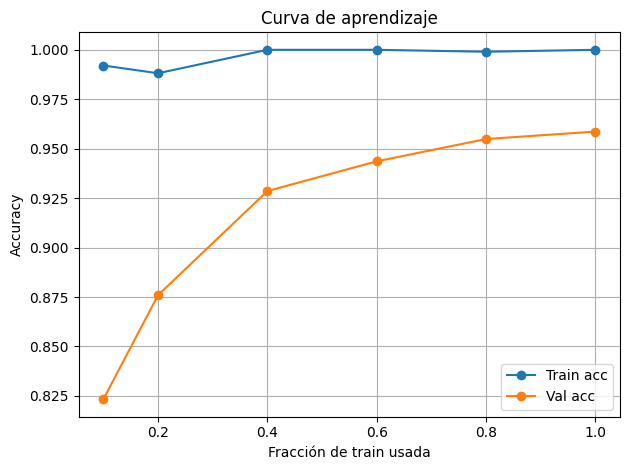

In [64]:
import numpy as np
import matplotlib.pyplot as plt

fracs = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
train_scores, val_scores = [], []

rng = np.random.RandomState(7)
for f in fracs:
    n = int(len(y_train) * f)
    idx = rng.permutation(len(y_train))[:n]
    X_tr, y_tr = X_train[idx], y_train[idx]

    m = NeuralNet(learning_rate=0.01, activation_function='ReLu',
                  layer_neurons=[32,16], epoch=200, batch_size=32)
    m.fit(X_tr, y_tr)

    map_m = {c:i for i,c in enumerate(m.classes)}
    y_tr_idx = np.array([map_m[l] for l in y_tr])
    y_va_idx = np.array([map_m[l] for l in y_val])

    train_scores.append((m.predict(X_tr) == y_tr_idx).mean())
    val_scores.append((m.predict((X_val_raw - mean_train)/std_train) == y_va_idx).mean())

plt.plot(fracs, train_scores, '-o', label='Train acc')
plt.plot(fracs, val_scores,  '-o', label='Val acc')
plt.xlabel('Fracción de train usada'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.title('Curva de aprendizaje'); plt.tight_layout(); plt.show()

In [65]:
# Cross-validation para evaluar robustez sobre el conjunto de entrenamiento
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
accs = []

for tr_idx, va_idx in kf.split(X_train_raw, y_train):
    X_tr, X_va = X_train_raw[tr_idx], X_train_raw[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]

    # Escalado por fold usando solo el train
    mean_tr = X_tr.mean(axis=0)
    std_tr = X_tr.std(axis=0)
    std_tr = np.where((~np.isfinite(std_tr)) | (std_tr == 0), 1.0, std_tr)
    X_tr_s = (X_tr - mean_tr) / std_tr
    X_va_s = (X_va - mean_tr) / std_tr

    model_cv = NeuralNet(
        learning_rate=0.01,
        activation_function='ReLu',
        layer_neurons=[32, 16],
        epoch=200,
        batch_size=32
    )
    model_cv.fit(X_tr_s, y_tr)
    y_pred_idx = model_cv.predict(X_va_s)
    y_pred = np.array(model_cv.classes)[y_pred_idx]
    accs.append((y_pred == y_va).mean())

print(f"CV Accuracy (5 folds): mean={np.mean(accs):.3f} ± {np.std(accs):.3f}")


Epoch   1 | loss=2.4647 | acc=0.206
Epoch  10 | loss=0.9464 | acc=0.732
Epoch  20 | loss=0.3966 | acc=0.914
Epoch  30 | loss=0.2294 | acc=0.955
Epoch  40 | loss=0.1538 | acc=0.972
Epoch  50 | loss=0.1116 | acc=0.983
Epoch  60 | loss=0.0848 | acc=0.990
Epoch  70 | loss=0.0662 | acc=0.992
Epoch  80 | loss=0.0534 | acc=0.994
Epoch  90 | loss=0.0437 | acc=0.996
Epoch 100 | loss=0.0367 | acc=0.997
Epoch 110 | loss=0.0313 | acc=0.998
Epoch 120 | loss=0.0272 | acc=0.999
Epoch 130 | loss=0.0232 | acc=1.000
Epoch  70 | loss=0.0662 | acc=0.992
Epoch  80 | loss=0.0534 | acc=0.994
Epoch  90 | loss=0.0437 | acc=0.996
Epoch 100 | loss=0.0367 | acc=0.997
Epoch 110 | loss=0.0313 | acc=0.998
Epoch 120 | loss=0.0272 | acc=0.999
Epoch 130 | loss=0.0232 | acc=1.000
Epoch 140 | loss=0.0208 | acc=1.000
Epoch 150 | loss=0.0181 | acc=1.000
Epoch 160 | loss=0.0164 | acc=1.000
Epoch 170 | loss=0.0147 | acc=1.000
Epoch 180 | loss=0.0136 | acc=1.000
Epoch 190 | loss=0.0123 | acc=1.000
Epoch 140 | loss=0.0208 | ac

Epoch   1 | loss=2.7872 | acc=0.224
Epoch  10 | loss=0.6443 | acc=0.858
Epoch  20 | loss=0.2681 | acc=0.935
Epoch  30 | loss=0.1661 | acc=0.962
Epoch  40 | loss=0.1142 | acc=0.980
Epoch  50 | loss=0.0860 | acc=0.989
Epoch  60 | loss=0.0669 | acc=0.993
Epoch  70 | loss=0.0547 | acc=0.994
Epoch  80 | loss=0.0453 | acc=0.994
Epoch  90 | loss=0.0384 | acc=0.994
Epoch 100 | loss=0.0327 | acc=0.995
Epoch 110 | loss=0.0280 | acc=0.997
Epoch 120 | loss=0.0242 | acc=0.998
Epoch 130 | loss=0.0212 | acc=0.999
Epoch 140 | loss=0.0185 | acc=0.999
Epoch 150 | loss=0.0164 | acc=1.000
Epoch 160 | loss=0.0147 | acc=1.000
Epoch 170 | loss=0.0132 | acc=1.000
Epoch 180 | loss=0.0122 | acc=1.000
Epoch 190 | loss=0.0109 | acc=1.000
Epoch 200 | loss=0.0101 | acc=1.000
=== Modelo Regularizado L1 ===
Train  acc=1.000 loss=0.010
Val    acc=0.966 loss=0.214 gap=0.034
Test   acc=0.966 loss=0.199 gap=0.034

Reporte clasificación (Test - L1):
              precision    recall  f1-score   support

           0      

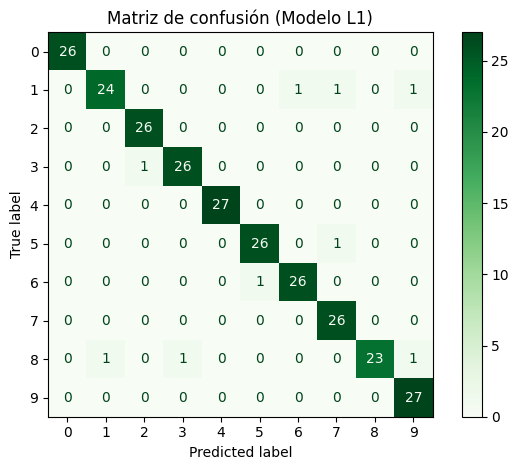

In [75]:
# Entrenar y evaluar el modelo con regularización L1
modelo_reg_L1 = NeuralNet(
    learning_rate=0.01,
    activation_function='ReLu',
    layer_neurons=[32, 16],
    epoch=200,
    batch_size=32,
    regularization_method='L1',
    lambda_reg=0.01
)

modelo_reg_L1.fit(X_train, y_train)

# Predicciones
pred_tr_L1 = modelo_reg_L1.predict(X_train)
pred_va_L1 = modelo_reg_L1.predict(X_val_s)
pred_te_L1 = modelo_reg_L1.predict(X_test)

map_L1 = {c:i for i,c in enumerate(modelo_reg_L1.classes)}
y_train_idx_L1 = np.array([map_L1[l] for l in y_train])
y_val_idx_L1   = np.array([map_L1[l] for l in y_val])
y_test_idx_L1  = np.array([map_L1[l] for l in y_test])

p_tr_L1, _, _ = modelo_reg_L1._forward(X_train)
p_va_L1, _, _ = modelo_reg_L1._forward(X_val_s)
p_te_L1, _, _ = modelo_reg_L1._forward(X_test)

loss_tr_L1 = modelo_reg_L1._CategoricalCrossEntropy(y_train_idx_L1, p_tr_L1)
loss_va_L1 = modelo_reg_L1._CategoricalCrossEntropy(y_val_idx_L1, p_va_L1)
loss_te_L1 = modelo_reg_L1._CategoricalCrossEntropy(y_test_idx_L1, p_te_L1)

acc_tr_L1 = (pred_tr_L1 == y_train_idx_L1).mean()
acc_va_L1 = (pred_va_L1 == y_val_idx_L1).mean()
acc_te_L1 = (pred_te_L1 == y_test_idx_L1).mean()

print("=== Modelo Regularizado L1 ===")
print(f"Train  acc={acc_tr_L1:.3f} loss={loss_tr_L1:.3f}")
print(f"Val    acc={acc_va_L1:.3f} loss={loss_va_L1:.3f} gap={acc_tr_L1-acc_va_L1:.3f}")
print(f"Test   acc={acc_te_L1:.3f} loss={loss_te_L1:.3f} gap={acc_tr_L1-acc_te_L1:.3f}")

from sklearn.metrics import classification_report
print("\nReporte clasificación (Test - L1):")
print(classification_report(y_test_idx_L1, pred_te_L1, digits=3))

resultados_modelos['L1'] = {
    'train_acc': acc_tr_L1,
    'val_acc': acc_va_L1,
    'test_acc': acc_te_L1,
    'train_loss': loss_tr_L1,
    'val_loss': loss_va_L1,
    'test_loss': loss_te_L1
}

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_L1 = confusion_matrix(y_test_idx_L1, pred_te_L1)
ConfusionMatrixDisplay(cm_L1).plot(cmap='Greens', values_format='d')
plt.title('Matriz de confusión (Modelo L1)')
plt.tight_layout(); plt.show()